# Churn — hackathon ONE / Data Science

In [3]:
%%capture
# Bibliotecas
import warnings
warnings.filterwarnings('ignore')

%pip install pandas numpy matplotlib seaborn scikit-learn joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from matplotlib.colors import LogNorm

import joblib

# 1. Carregamento e visão geral dos dados

In [6]:
df = pd.read_csv('data/Churn.csv')

print(f"Formato do dataset: {df.shape}")
display(df.head())

print("\n📊 Informações do Dataset:\n")
print(df.info())

print("\n📌 Estatísticas descritivas:\n")
display(df.describe())

print("\n🎯 Distribuição do Target (Exited):\n")
print(df['Exited'].value_counts(normalize=True))

Formato do dataset: (10000, 11)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,EstimatedSalary,Exited
0,747,15787619,Hsieh,844,France,Male,18,2,160980.03,145936.28,0
1,1620,15770309,McDonald,656,France,Male,18,10,151762.74,127014.32,0
2,1679,15569178,Kharlamov,570,France,Female,18,4,82767.42,71811.90,0
3,2022,15795519,Vasiliev,716,Germany,Female,18,3,128743.80,197322.13,0
4,2137,15621893,Bellucci,727,France,Male,18,4,133550.67,46941.41,0



📊 Informações do Dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 859.5+ KB
None

📌 Estatísticas descritivas:



,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,199992.480000,1.000000



🎯 Distribuição do Target (Exited):

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


# 2. EDA rápida (histogramas e correlações)

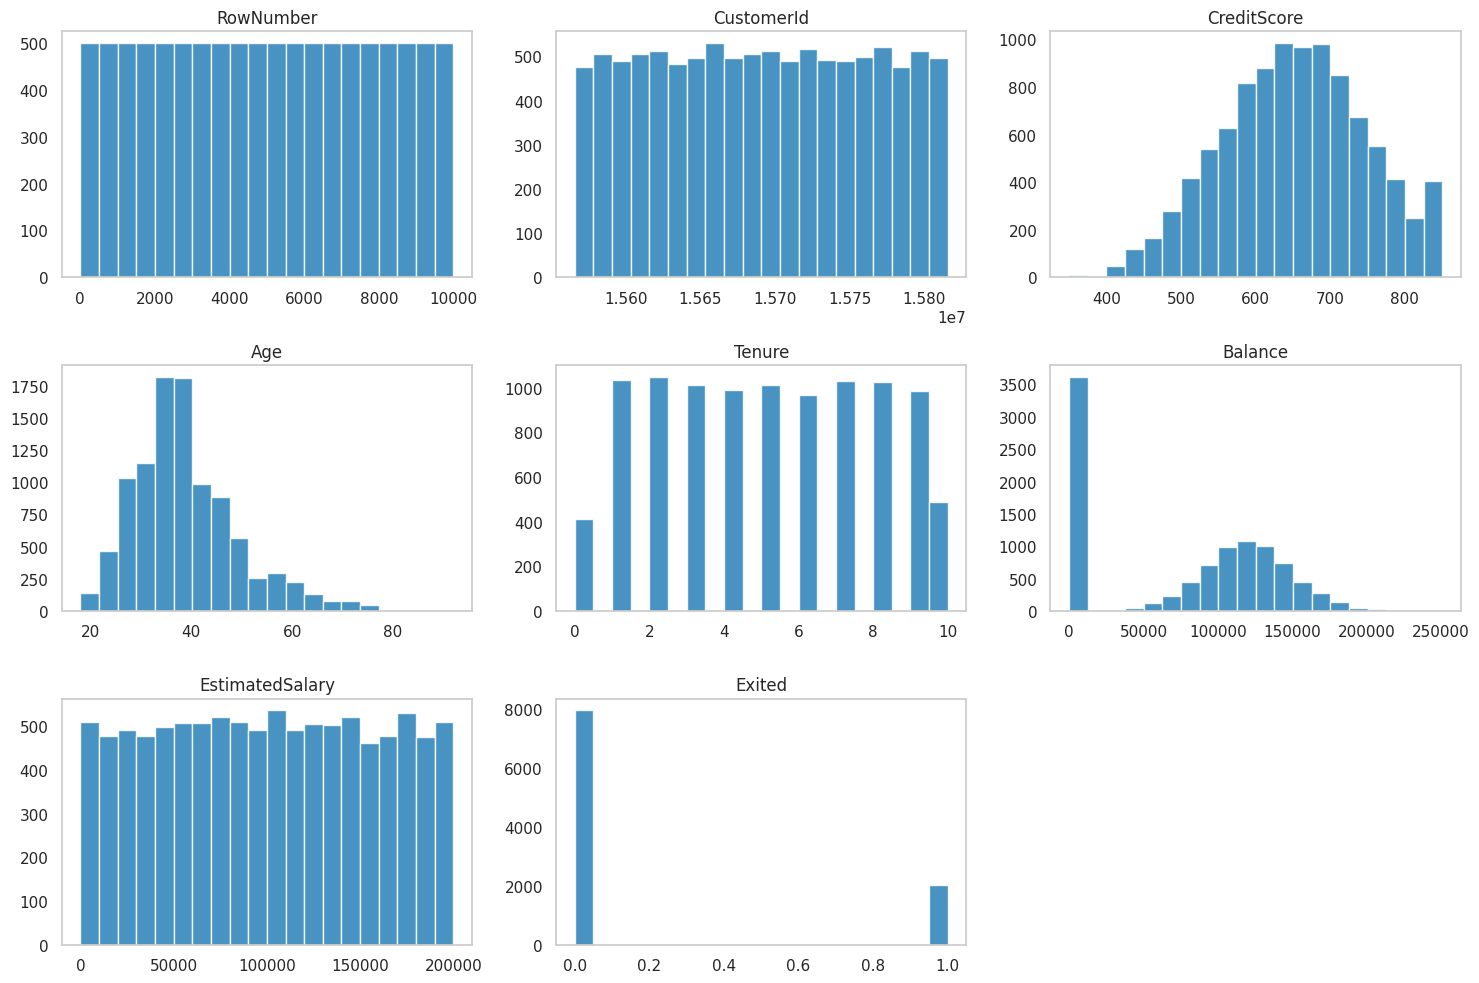

In [17]:
# Histograma das variáveis numéricas
axes = df.hist(
    bins=20,
    figsize=(15, 10),
    color='#2980B9',
    edgecolor='white',
    alpha=0.85
)
for ax in axes.flatten():
    ax.grid(False)

plt.tight_layout()
plt.show()

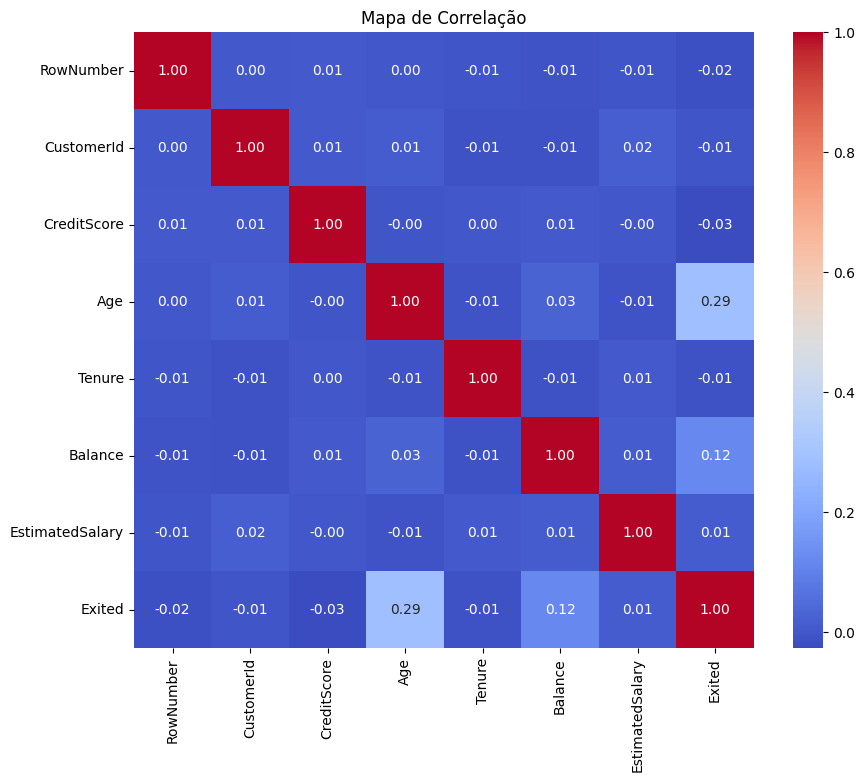

In [9]:
# Heatmap de correlação
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Correlação')
plt.show()

# 3. Pré-processamento inicial (SEM feature engineering ainda)

In [10]:
 # Remove colunas de ID
df_clean = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Codifica variáveis categóricas com One-Hot Encoding
df_encoded = pd.get_dummies(
    df_clean,
    columns=['Geography', 'Gender'],
    drop_first=True,
    dtype=int
)

print("\n✅ Encoding concluído. Novas colunas:\n", df_encoded.columns.tolist())
display(df_encoded.head())


✅ Encoding concluído. Novas colunas:
 ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Exited', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,844,18,2,160980.03,145936.28,0,0,0,1
1,656,18,10,151762.74,127014.32,0,0,0,1
2,570,18,4,82767.42,71811.90,0,0,0,0
3,716,18,3,128743.80,197322.13,0,1,0,0
4,727,18,4,133550.67,46941.41,0,0,0,1


# 4. Split treino / validação / teste (ANTES da feature engineering)

In [11]:
X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

# 60% treino, 20% validação, 20% teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\n📊 Split realizado:")
print(f"Treino: {X_train.shape[0]} | Validação: {X_val.shape[0]} | Teste: {X_test.shape[0]}")


📊 Split realizado:
Treino: 6000 | Validação: 2000 | Teste: 2000


# 5. Feature Engineering (APENAS com dados de treino)

In [18]:
# Calcula medianas APENAS no conjunto de treino
balance_median = X_train['Balance'].median()
salary_median = X_train['EstimatedSalary'].median()

print(f"\n📈 Medianas calculadas no treino:")
print(f"Balance: {balance_median:.2f}")
print(f"Salary: {salary_median:.2f}")

# Função para criar features derivadas
def create_derived_features(df, balance_med, salary_med):
    """Cria features derivadas aplicando as medianas do treino"""
    df = df.copy()

    df['Balance_Salary_Ratio'] = df['Balance'] / (df['EstimatedSalary'] + 1)
    df['Age_Tenure'] = df['Age'] * df['Tenure']
    df['High_Value_Customer'] = (
        (df['Balance'] > balance_med) &
        (df['EstimatedSalary'] > salary_med)
    ).astype(int)

    return df

# Aplica em todos os conjuntos usando as medianas do TREINO
X_train = create_derived_features(X_train, balance_median, salary_median)
X_val = create_derived_features(X_val, balance_median, salary_median)
X_test = create_derived_features(X_test, balance_median, salary_median)

print("\n✅ Features derivadas criadas. Formato final:")
print(f"Treino: {X_train.shape}")
display(X_train.head())


📈 Medianas calculadas no treino:
Balance: 97940.80
Salary: 100444.88

✅ Features derivadas criadas. Formato final:
Treino: (6000, 11)


,CreditScore,Age,Tenure,Balance,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Balance_Salary_Ratio,Age_Tenure,High_Value_Customer
1707,850,30,5,123210.56,102180.27,1,0,1,1.205804,150,1
2326,731,31,1,132512.26,185466.85,0,0,1,0.714476,31,1
4525,725,36,1,118851.05,102747.02,0,0,0,1.156724,36,1
6892,850,42,9,113311.11,198193.75,0,0,0,0.571716,378,1
1044,589,28,7,0.00,151645.96,0,0,1,0.000000,196,0


# 6. Normalização (StandardScaler)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 7. Modelo baseline (RandomForest simples na validação)

In [20]:
rf_base = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    n_jobs=-1
)
rf_base.fit(X_train_scaled, y_train)

y_val_pred_base = rf_base.predict(X_val_scaled)

print("\n📈 Desempenho - Modelo Baseline (validação):\n")
print(classification_report(y_val, y_val_pred_base))
print(f"Acurácia (validação): {accuracy_score(y_val, y_val_pred_base):.3f}")


📈 Desempenho - Modelo Baseline (validação):

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1593
           1       0.59      0.31      0.40       407

    accuracy                           0.82      2000
   macro avg       0.72      0.63      0.65      2000
weighted avg       0.79      0.82      0.79      2000

Acurácia (validação): 0.816


# 8. Modelo focado em churn (balanceado) na validação


📈 Desempenho - Modelo Balanceado (validação, threshold=0.35):
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1593
           1       0.47      0.45      0.46       407

    accuracy                           0.79      2000
   macro avg       0.67      0.66      0.66      2000
weighted avg       0.78      0.79      0.78      2000

Acurácia: 0.785
ROC-AUC: 0.7538154487307029


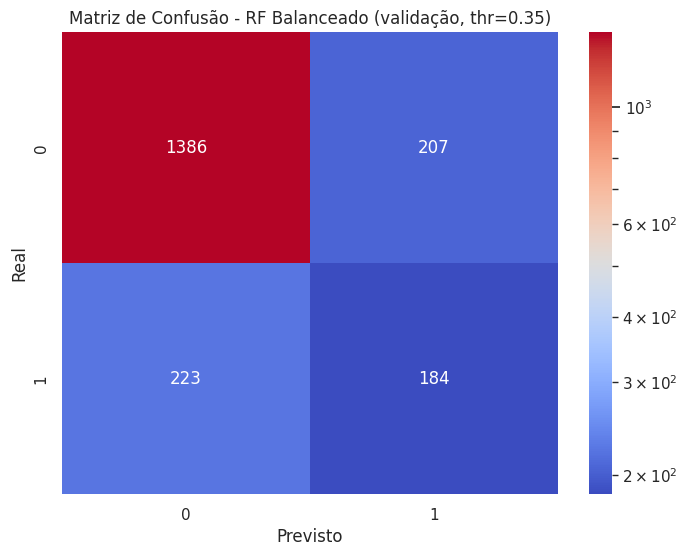


✅ O modelo balanceado foi escolhido como modelo final por ter melhor recall/f1 para a classe churn.


In [21]:
rf_bal = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight={0: 1, 1: 3}
)
rf_bal.fit(X_train_scaled, y_train)

y_val_proba_bal = rf_bal.predict_proba(X_val_scaled)[:, 1]
threshold = 0.35
y_val_pred_bal = (y_val_proba_bal >= threshold).astype(int)

print(f"\n📈 Desempenho - Modelo Balanceado (validação, threshold={threshold}):")
print(classification_report(y_val, y_val_pred_bal))
print("Acurácia:", accuracy_score(y_val, y_val_pred_bal))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba_bal))

cm_val = confusion_matrix(y_val, y_val_pred_bal)
plt.figure(figsize=(8, 6))

sns.heatmap(cm_val, annot=True, fmt='d', cmap='coolwarm', norm=LogNorm())

plt.title(f'Matriz de Confusão - RF Balanceado (validação, thr={threshold})')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

print("\n✅ O modelo balanceado foi escolhido como modelo final por ter melhor recall/f1 para a classe churn.")

# 9. Treinar modelo final (treino + validação) e avaliar no TESTE


📈 Desempenho FINAL no TESTE:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1593
           1       0.48      0.48      0.48       407

    accuracy                           0.79      2000
   macro avg       0.68      0.67      0.67      2000
weighted avg       0.79      0.79      0.79      2000

Acurácia: 0.79
ROC-AUC: 0.7669210042091399


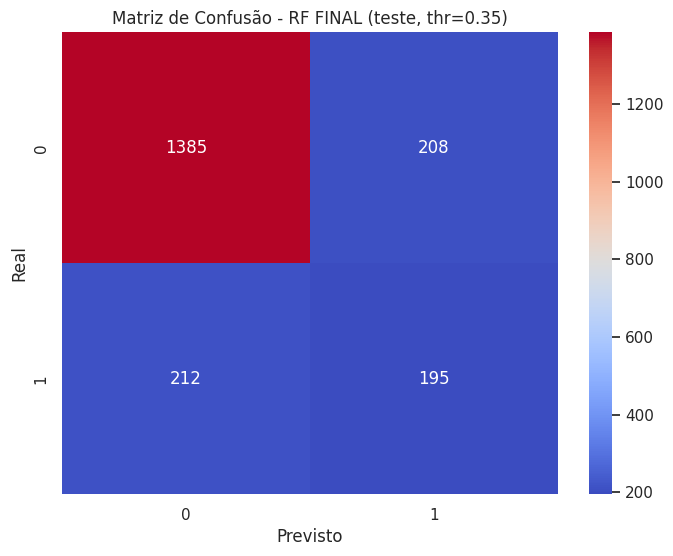

In [22]:
# Junta treino e validação
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Reajusta scaler com treino completo
scaler_final = StandardScaler()
X_train_full_scaled = scaler_final.fit_transform(X_train_full)
X_test_scaled = scaler_final.transform(X_test)

rf_final = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight={0: 1, 1: 3}
)
rf_final.fit(X_train_full_scaled, y_train_full)

y_test_proba = rf_final.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)

print("\n📈 Desempenho FINAL no TESTE:")
print(classification_report(y_test, y_test_pred))
print("Acurácia:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='coolwarm')
plt.title(f'Matriz de Confusão - RF FINAL (teste, thr={threshold})')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

# 10. IMPORTÂNCIA DAS FEATURES

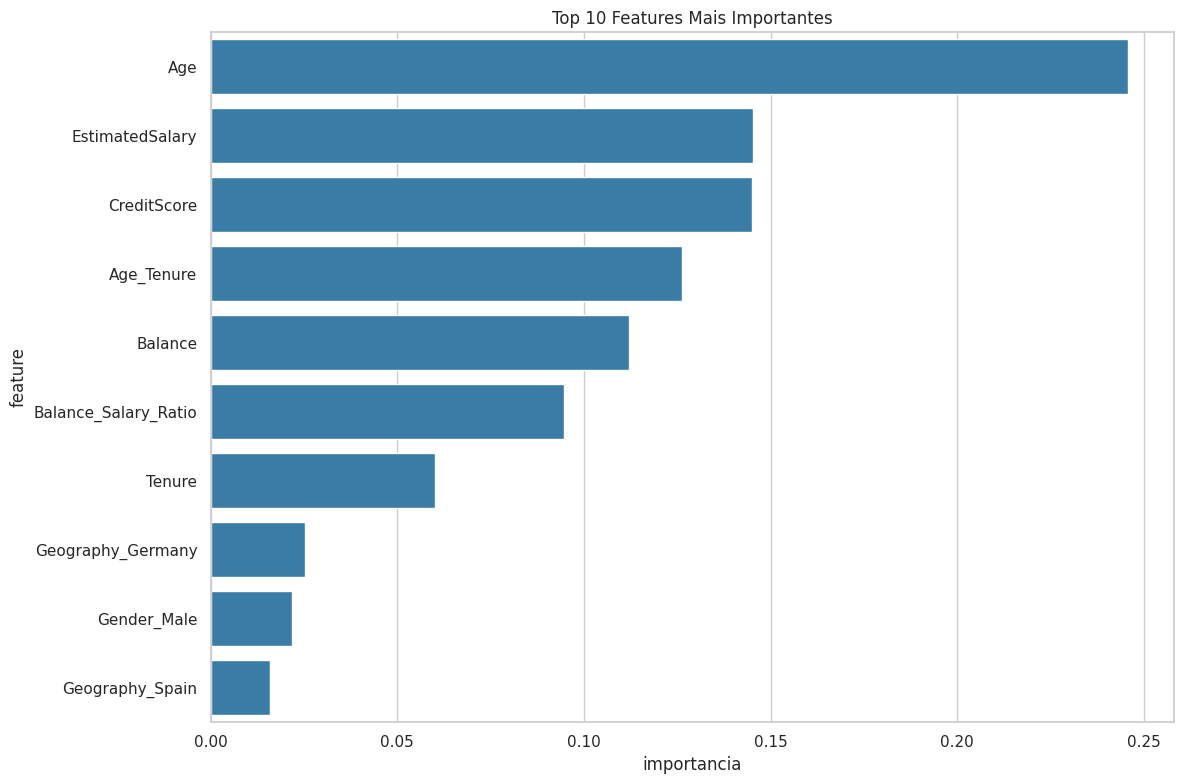


🏆 TOP FEATURES:

                feature  importancia
1                   Age     0.245774
4       EstimatedSalary     0.145245
0           CreditScore     0.145015
9            Age_Tenure     0.126249
3               Balance     0.112188
8  Balance_Salary_Ratio     0.094690
2                Tenure     0.060080
5     Geography_Germany     0.025325
7           Gender_Male     0.021751
6       Geography_Spain     0.016011


In [23]:
importances = pd.DataFrame({
    'feature': X_train_full.columns,
    'importancia': rf_final.feature_importances_
}).sort_values('importancia', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=importances.head(10),
    x='importancia',
    y='feature',
    color='#2980B9',
)
plt.title('Top 10 Features Mais Importantes')
plt.tight_layout()
plt.show()

print("\n🏆 TOP FEATURES:\n")
print(importances.head(10))

# 11. FUNÇÕES DE PREDIÇÃO (CONTRATO PARA A API)

In [24]:
FEATURES_ORIGINAIS = [
    'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'EstimatedSalary'
]

def preprocess_one_customer(data: dict) -> np.ndarray:
    """
    Recebe um dicionário com os campos do cliente e
    retorna um array pronto para o modelo, com todas
    as features derivadas e escalonamento aplicado.
    """
    temp = pd.DataFrame([data], columns=FEATURES_ORIGINAIS)
    
    # One-Hot Encoding
    temp = pd.get_dummies(
        temp,
        columns=['Geography', 'Gender'],
        drop_first=True,
        dtype=int
    )
    
    # Garantir que todas as colunas existam
    for col in ['Geography_Germany', 'Geography_Spain', 'Gender_Male']:
        if col not in temp.columns:
            temp[col] = 0

    # Features derivadas (mesmo cálculo do treino)
    temp['Balance_Salary_Ratio'] = temp['Balance'] / (temp['EstimatedSalary'] + 1)
    temp['Age_Tenure'] = temp['Age'] * temp['Tenure']
    temp['High_Value_Customer'] = (
        (temp['Balance'] > balance_median) & 
        (temp['EstimatedSalary'] > salary_median)
    ).astype(int)
    
    # Garantir mesma ordem das colunas do treino
    for col in X_train.columns:
        if col not in temp.columns:
            temp[col] = 0
    temp = temp[X_train.columns]

    # Escalamento
    return scaler.transform(temp)

def calculate_risk(proba: float) -> tuple[str, str]:
    """
    Classifica o risco baseado no threshold do modelo,
    igual ao main.py da API.
    """
    if proba >= threshold:
        return "ALTO", "Ação imediata recomendada: contato ativo e oferta personalizada"
    else:
        return "BAIXO", "Cliente estável"

def predict_churn(data: dict) -> dict:
    """
    Predição de churn para um único cliente,
    seguindo o contrato da API.
    """
    x = preprocess_one_customer(data)
    proba = rf_final.predict_proba(x)[0, 1]
    pred = int(proba >= threshold)
    
    risco, recomendacao = calculate_risk(proba)
    
    # Explicabilidade simples: top 3 features
    importances = rf_final.feature_importances_
    impactos = importances * np.abs(x[0])
    ranking = sorted(zip(X_train.columns, impactos), key=lambda x: x[1], reverse=True)[:3]
    explicabilidade = [f[0] for f in ranking]

    return {
        "previsao": "Vai cancelar" if pred == 1 else "Vai continuar",
        "probabilidade": float(round(proba, 4)),
        "nivel_risco": risco,
        "recomendacao": recomendacao,
        "explicabilidade": explicabilidade
    }

# ===========================
# Teste rápido
# ===========================
exemplo_cliente = {
    "CreditScore": 650,
    "Geography": "France",
    "Gender": "Male",
    "Age": 40,
    "Tenure": 5,
    "Balance": 60000.0,
    "EstimatedSalary": 80000.0
}

resultado = predict_churn(exemplo_cliente)
print("\n🧪 Teste de predição:")
for key, value in resultado.items():
    print(f"  {key}: {value}")


🧪 Teste de predição:
  previsao: Vai continuar
  probabilidade: 0.205
  nivel_risco: BAIXO
  recomendacao: Cliente estável
  explicabilidade: ['EstimatedSalary', 'Balance', 'Age']


# 12. Salvando pipeline 

In [25]:
# Instalação 
!pip install pyarrow

In [26]:
# Exportar Dataset 
df_encoded.to_parquet('dataset.parquet', compression='snappy')

# Exportar Artefatos do Modelo 
import joblib, os

os.makedirs("model", exist_ok=True)

artefatos = {
    "model": rf_final,
    "scaler": scaler_final,
    "columns": list(X_train_full.columns),
    "threshold": 0.35,
    "balance_median": balance_median, 
    "salary_median": salary_median  
}

joblib.dump(artefatos, "model/model.joblib")

print("✅ Arquivos salvos!")

✅ Arquivos salvos!


# ⚠️ TESTE

In [27]:

# Carrega os artefatos
modelo_carregado = joblib.load("model/model.joblib")

print("\n🧪 Teste de Carregamento:")
print(f"✅ Modelo: {type(modelo_carregado['model'])}")
print(f"✅ Scaler: {type(modelo_carregado['scaler'])}")
print(f"✅ Colunas: {len(modelo_carregado['columns'])} features")
print(f"✅ Threshold: {modelo_carregado['threshold']}")
print(f"✅ Balance Median: {modelo_carregado['balance_median']:.2f}")

# Teste de predição
exemplo = {
    "CreditScore": 650,
    "Geography": "France",
    "Gender": "Male",
    "Age": 40,
    "Tenure": 5,
    "Balance": 60000.0,
    "EstimatedSalary": 80000.0
}

resultado = predict_churn(exemplo)
print(f"\n✅ Predição funciona: {resultado['previsao']}")


🧪 Teste de Carregamento:
✅ Modelo: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
✅ Scaler: <class 'sklearn.preprocessing._data.StandardScaler'>
✅ Colunas: 11 features
✅ Threshold: 0.35
✅ Balance Median: 97940.80

✅ Predição funciona: Vai continuar


In [28]:

# Carrega apenas UMA vez ao iniciar
artefatos = joblib.load("model/model.joblib")
modelo = artefatos['model']
scaler = artefatos['scaler']

In [29]:
# Teste com cliente REALMENTE crítico
cliente_critico = {
    "CreditScore": 350,      # Mínimo do dataset
    "Geography": "Germany",  # País com mais churn
    "Gender": "Female",      # Ligeiramente mais churn
    "Age": 55,               # Idade de alto risco
    "Tenure": 8,             # Cliente antigo
    "Balance": 0.0,          # Zerou a conta!
    "EstimatedSalary": 15000.0  # Salário muito baixo
}

print("\n🚨 Cliente CRÍTICO:")
resultado_critico = predict_churn(cliente_critico)
for key, value in resultado_critico.items():
    print(f"  {key}: {value}")

# ---

# Teste com cliente de churn moderado
cliente_moderado = {
    "CreditScore": 500,
    "Geography": "Germany",
    "Gender": "Female",
    "Age": 45,
    "Tenure": 2,
    "Balance": 125000.0,     # Alto Balance
    "EstimatedSalary": 180000.0  # Alto Salário
}

print("\n⚠️ Cliente MODERADO:")
resultado_moderado = predict_churn(cliente_moderado)
for key, value in resultado_moderado.items():
    print(f"  {key}: {value}")


🚨 Cliente CRÍTICO:
  previsao: Vai cancelar
  probabilidade: 0.39
  nivel_risco: ALTO
  recomendacao: Ação imediata recomendada: contato ativo e oferta personalizada
  explicabilidade: ['CreditScore', 'Age', 'Age_Tenure']

⚠️ Cliente MODERADO:
  previsao: Vai cancelar
  probabilidade: 0.6
  nivel_risco: ALTO
  recomendacao: Ação imediata recomendada: contato ativo e oferta personalizada
  explicabilidade: ['CreditScore', 'EstimatedSalary', 'Age']
